In [1]:
import matplotlib.pyplot as plt
from itertools import cycle
from matplotlib.pyplot import cm

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import integrate
from csaps import csaps

from pathlib import Path

import functions as f

In [2]:
INPUT_DIR = Path('./../gamma=2.0/')

In [3]:
snapshots = [0, 10, 20, 50, 100, 200, 400]

In [4]:
bounds = np.array([[1, 50000], [1e-2, 10], [1e-9, 3]])
r_e = np.geomspace(1e-1, 50, 101)
init_vals = np.array([100, 0.5, 1])
dmdr_3D = pd.DataFrame(data={'r':r_e})
dmdr_2D = pd.DataFrame(data={'r':r_e})
popts_3D = pd.DataFrame()
popts_2D = pd.DataFrame()

### in 3D

In [5]:
for snap in snapshots:
    dmdr = 0
    
    for random in [11, 12, 13, 21, 22, 23, 31, 32, 33]:
        folder = Path(f'{INPUT_DIR}/run-2.0-0.20-{random}')
        dmdr += f.get_dmdr(folder, snap, r_e)
        
    dmdr = dmdr / 9
    popt_dehnen_counts, pcov_dehnen_counts = curve_fit(f.dmdr_profile_3D, r_e, dmdr, 
                                                       bounds=bounds.T, p0=init_vals, maxfev=7000)
    
    dmdr_3D[snap] = dmdr
    popts_3D[snap] = popt_dehnen_counts

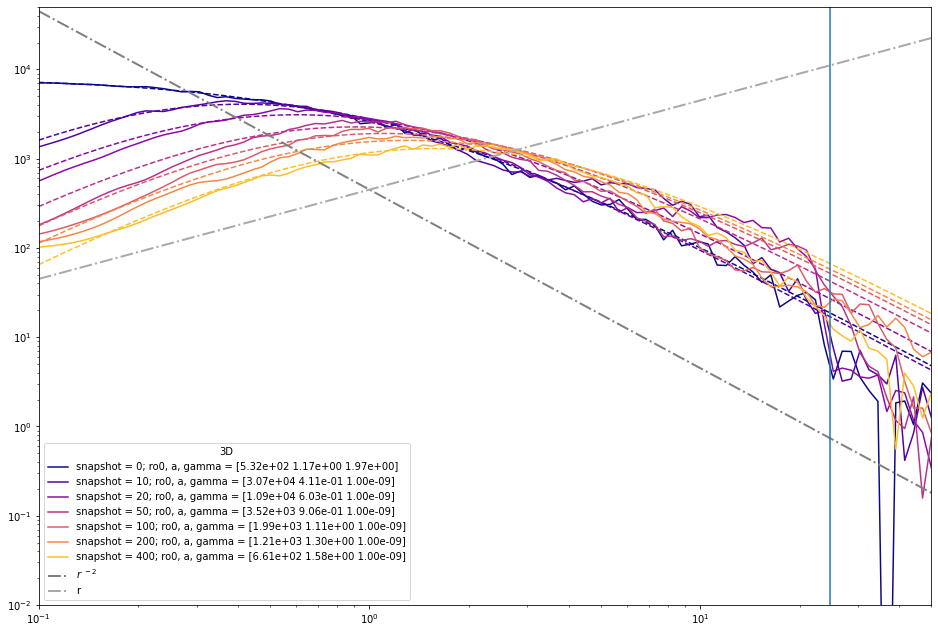

In [6]:
cycol = iter(cm.plasma(np.linspace(0, 1, len(snapshots)+1)))
np.set_printoptions(formatter={'float': "{0:0.2e}".format})

fig, ax = plt.subplots(figsize=(16, 11))
for snap in dmdr_3D.columns[1:]:
    c=next(cycol)
    ax.plot(dmdr_3D['r'], dmdr_3D[snap], label=f'snapshot = {snap}; ro0, a, gamma = {popts_3D[snap].values}', c=c)
    ax.plot(dmdr_3D['r'], f.dmdr_profile_3D(dmdr_3D['r'], *popts_3D[snap]), c=c, ls='--')
    
    
ax.plot(dmdr_3D['r'], 450 / dmdr_3D['r'] ** 2, c='gray', label=r'$r^{\ -2}$', ls= '-.', lw=2)
ax.plot(dmdr_3D['r'], 450 * dmdr_3D['r'] , c='darkgrey', label='r', ls= '-.', lw=2)
ax.plot([1.23 * 20, 1.23 * 20], [1e-3, 1e5])   
    
ax.set_ylim(1e-2,5e4)
ax.set_xlim(r_e.min(), r_e.max())
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(title='3D')

In [7]:
popts_3D # ro0, a, gamma

,0,10,20,50,100,200,400
0,531.767392,3.067126e+04,1.086608e+04,3.518508e+03,1.989180e+03,1.209750e+03,6.605265e+02
1,1.170207,4.113260e-01,6.033017e-01,9.064035e-01,1.107734e+00,1.298928e+00,1.582563e+00
2,1.967782,1.000003e-09,1.000011e-09,1.000016e-09,1.000016e-09,1.000006e-09,1.000007e-09


### in 2D

In [8]:
for snap in snapshots:
    dmdr = 0
    
    for random in [11, 12, 13, 21, 22, 23, 31, 32, 33]:
        folder = Path(f'{INPUT_DIR}/run-2.0-0.20-{random}')
        dmdr += f.get_dmdr(folder, snap, r_e)
    dmdr = dmdr / 9
    popt_dehnen_counts, pcov_dehnen_counts = curve_fit(f.dmdr_profile_2D, r_e, dmdr, 
                                                       bounds=bounds.T, p0=init_vals, maxfev=7000)
    
    dmdr_2D[snap] = dmdr
    popts_2D[snap] = popt_dehnen_counts

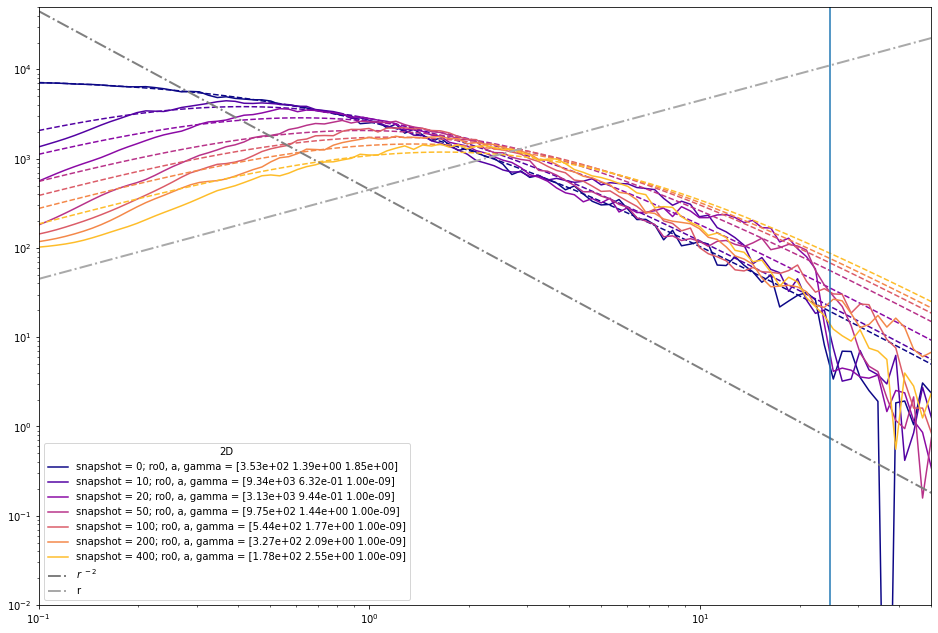

In [9]:
cycol = iter(cm.plasma(np.linspace(0, 1, len(snapshots)+1)))
np.set_printoptions(formatter={'float': "{0:0.2e}".format})

fig, ax = plt.subplots(figsize=(16, 11))
for snap in dmdr_2D.columns[1:]:
    c=next(cycol)
    ax.plot(dmdr_2D['r'], dmdr_2D[snap], label=f'snapshot = {snap}; ro0, a, gamma = {popts_2D[snap].values}', c=c)
    ax.plot(dmdr_2D['r'], f.dmdr_profile_2D(dmdr_2D['r'], *popts_2D[snap]), c=c, ls='--')
    
    
ax.plot(dmdr_3D['r'], 450 / dmdr_3D['r'] ** 2, c='gray', label=r'$r^{\ -2}$', ls= '-.', lw=2)
ax.plot(dmdr_3D['r'], 450 * dmdr_3D['r'] , c='darkgrey', label='r', ls= '-.', lw=2)
ax.plot([1.23 * 20, 1.23*20], [1e-3, 1e5])   
    
ax.set_ylim(1e-2,5e4)
ax.set_xlim(r_e.min(), r_e.max())

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(title='2D')

In [10]:
popts_2D # ro0, a, gamma

,0,10,20,50,100,200,400
0,353.474911,9.337382e+03,3.134007e+03,9.750241e+02,5.441079e+02,3.271715e+02,1.779567e+02
1,1.391713,6.319881e-01,9.444286e-01,1.437844e+00,1.766669e+00,2.085087e+00,2.547833e+00
2,1.851605,1.000003e-09,1.000000e-09,1.000000e-09,1.000099e-09,1.000005e-09,1.000000e-09
